# Hierarchical Bayesian model of binary choice
This notebook demonstrates the advantages when we have more data but also some regions with very little data.

Imagine a world where everyone chooses whether or not to open their windows. This choice is random, but the probability has some regional influence.

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy import stats
import numpy as np
import pymc3 as pm
import seaborn as sns

sns.set_style('darkgrid')

np.random.seed(434)

## Data
I make synthetic data:

In [13]:
# SECRET constants are the true population distribution that we can never know
SECRET_A = 2
SECRET_B = 5
SECRET_P_DIST = stats.beta(SECRET_A, SECRET_B)

In [14]:
REGIONS = range(10)

In [15]:
SECRET_P = SECRET_P_DIST.rvs(len(REGIONS))
SECRET_P

array([0.14360561, 0.07236543, 0.25310767, 0.32047349, 0.2760088 ,
       0.0414144 , 0.47965869, 0.65804003, 0.26908437, 0.40119353])

In [16]:
N_OBS = np.int64(np.linspace(1500, 5, num=len(REGIONS)))
N_OBS

array([1500, 1333, 1167, 1001,  835,  669,  503,  337,  171,    5],
      dtype=int64)

In [17]:
observed_counts = [stats.binom.rvs(n, p) for n, p in zip(N_OBS, SECRET_P)]
observed_counts

[202, 99, 302, 297, 219, 31, 273, 221, 41, 3]

Sanity check that simulated observations make sense:

In [19]:
observed_p = np.array(observed_counts)/np.array(N_OBS)
observed_p

array([0.13466667, 0.07426857, 0.2587832 , 0.2967033 , 0.26227545,
       0.04633782, 0.54274354, 0.65578635, 0.23976608, 0.6       ])

In [20]:
[stats.binom.cdf(k, n, p) for k, n, p in zip(observed_counts, N_OBS, SECRET_P)]

[0.17114899118236257,
 0.6309999395197256,
 0.685744289927275,
 0.05658682819506493,
 0.19837864687211226,
 0.7733762048242772,
 0.9979845064477022,
 0.48570380274596175,
 0.2197875193728436,
 0.9120401752059972]

Outside of this section, we cannot use SECRET variables because they are the true parameters we can never know exactly.

# Model
Based on https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

In [21]:
with pm.Model() as model:
    # see e.g. https://arxiv.org/abs/1104.4937 for support of half Cauchy priors
    a = pm.HalfCauchy("a", beta=1)
    b = pm.HalfCauchy("b", beta=1)

    theta = pm.Beta('theta', alpha=a, beta=b, shape=len(REGIONS))

    p = pm.Binomial('p', p=theta, observed=observed_counts, n=N_OBS)
    trace = pm.sample(5000, tune=1000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, b, a]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 24000/24000 [00:17<00:00, 1374.97draws/s]


C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argu

C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002087BC9AB00>,
      dtype=object)

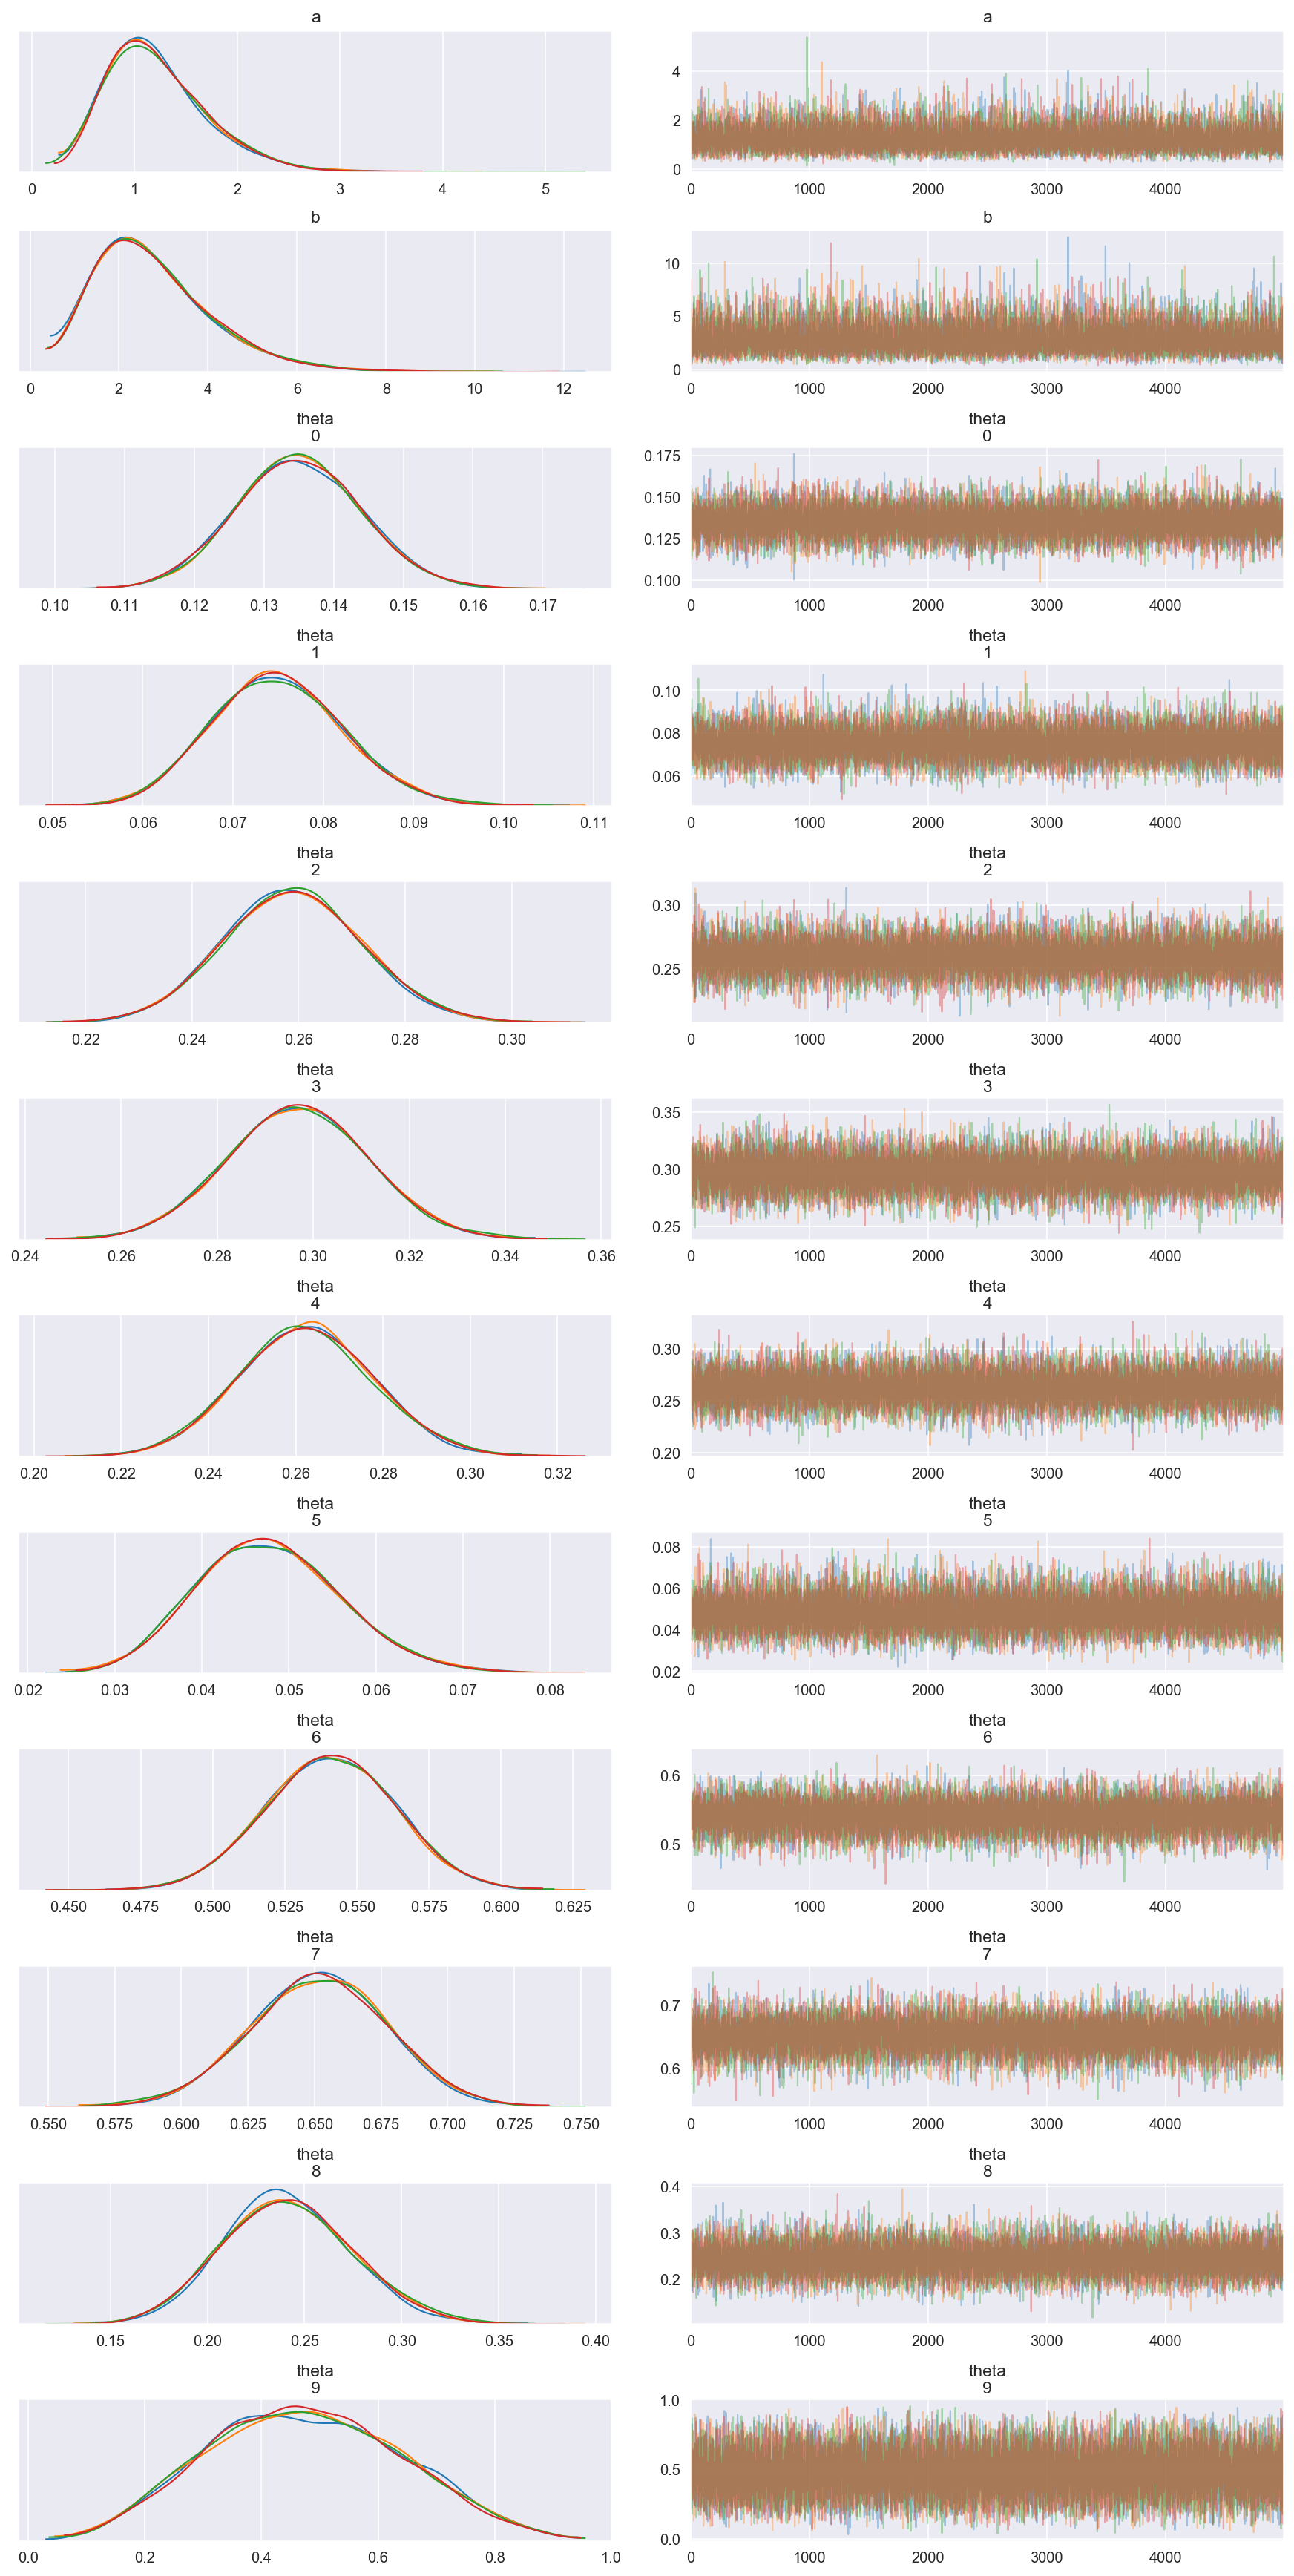

In [22]:
pm.traceplot(trace)

In [23]:
pm.summary(trace)

C:\Users\Immanuel\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.227916,0.489801,0.003538,0.396541,2.195118,14850.059792,1.000040
b,2.786903,1.314913,0.009765,0.723723,5.441186,14847.415238,1.000013
theta__0,0.135058,0.008746,0.000054,0.118269,0.152479,25298.919865,0.999918
theta__1,0.074989,0.007171,0.000043,0.061564,0.089389,23082.316670,0.999923
theta__2,0.258996,0.012795,0.000078,0.234177,0.284302,21168.704367,1.000053
theta__3,0.296920,0.014525,0.000093,0.267937,0.324806,21564.300146,0.999935
theta__4,0.262420,0.015141,0.000078,0.233062,0.292175,24381.559506,1.000039
theta__5,0.047846,0.008243,0.000050,0.032314,0.064217,22738.296421,0.999942
theta__6,0.540797,0.022084,0.000158,0.496946,0.583048,22149.906702,0.999925
theta__7,0.651608,0.025654,0.000189,0.601711,0.702139,19179.329323,0.999939


# Posterior check

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020805110518>,
      dtype=object)

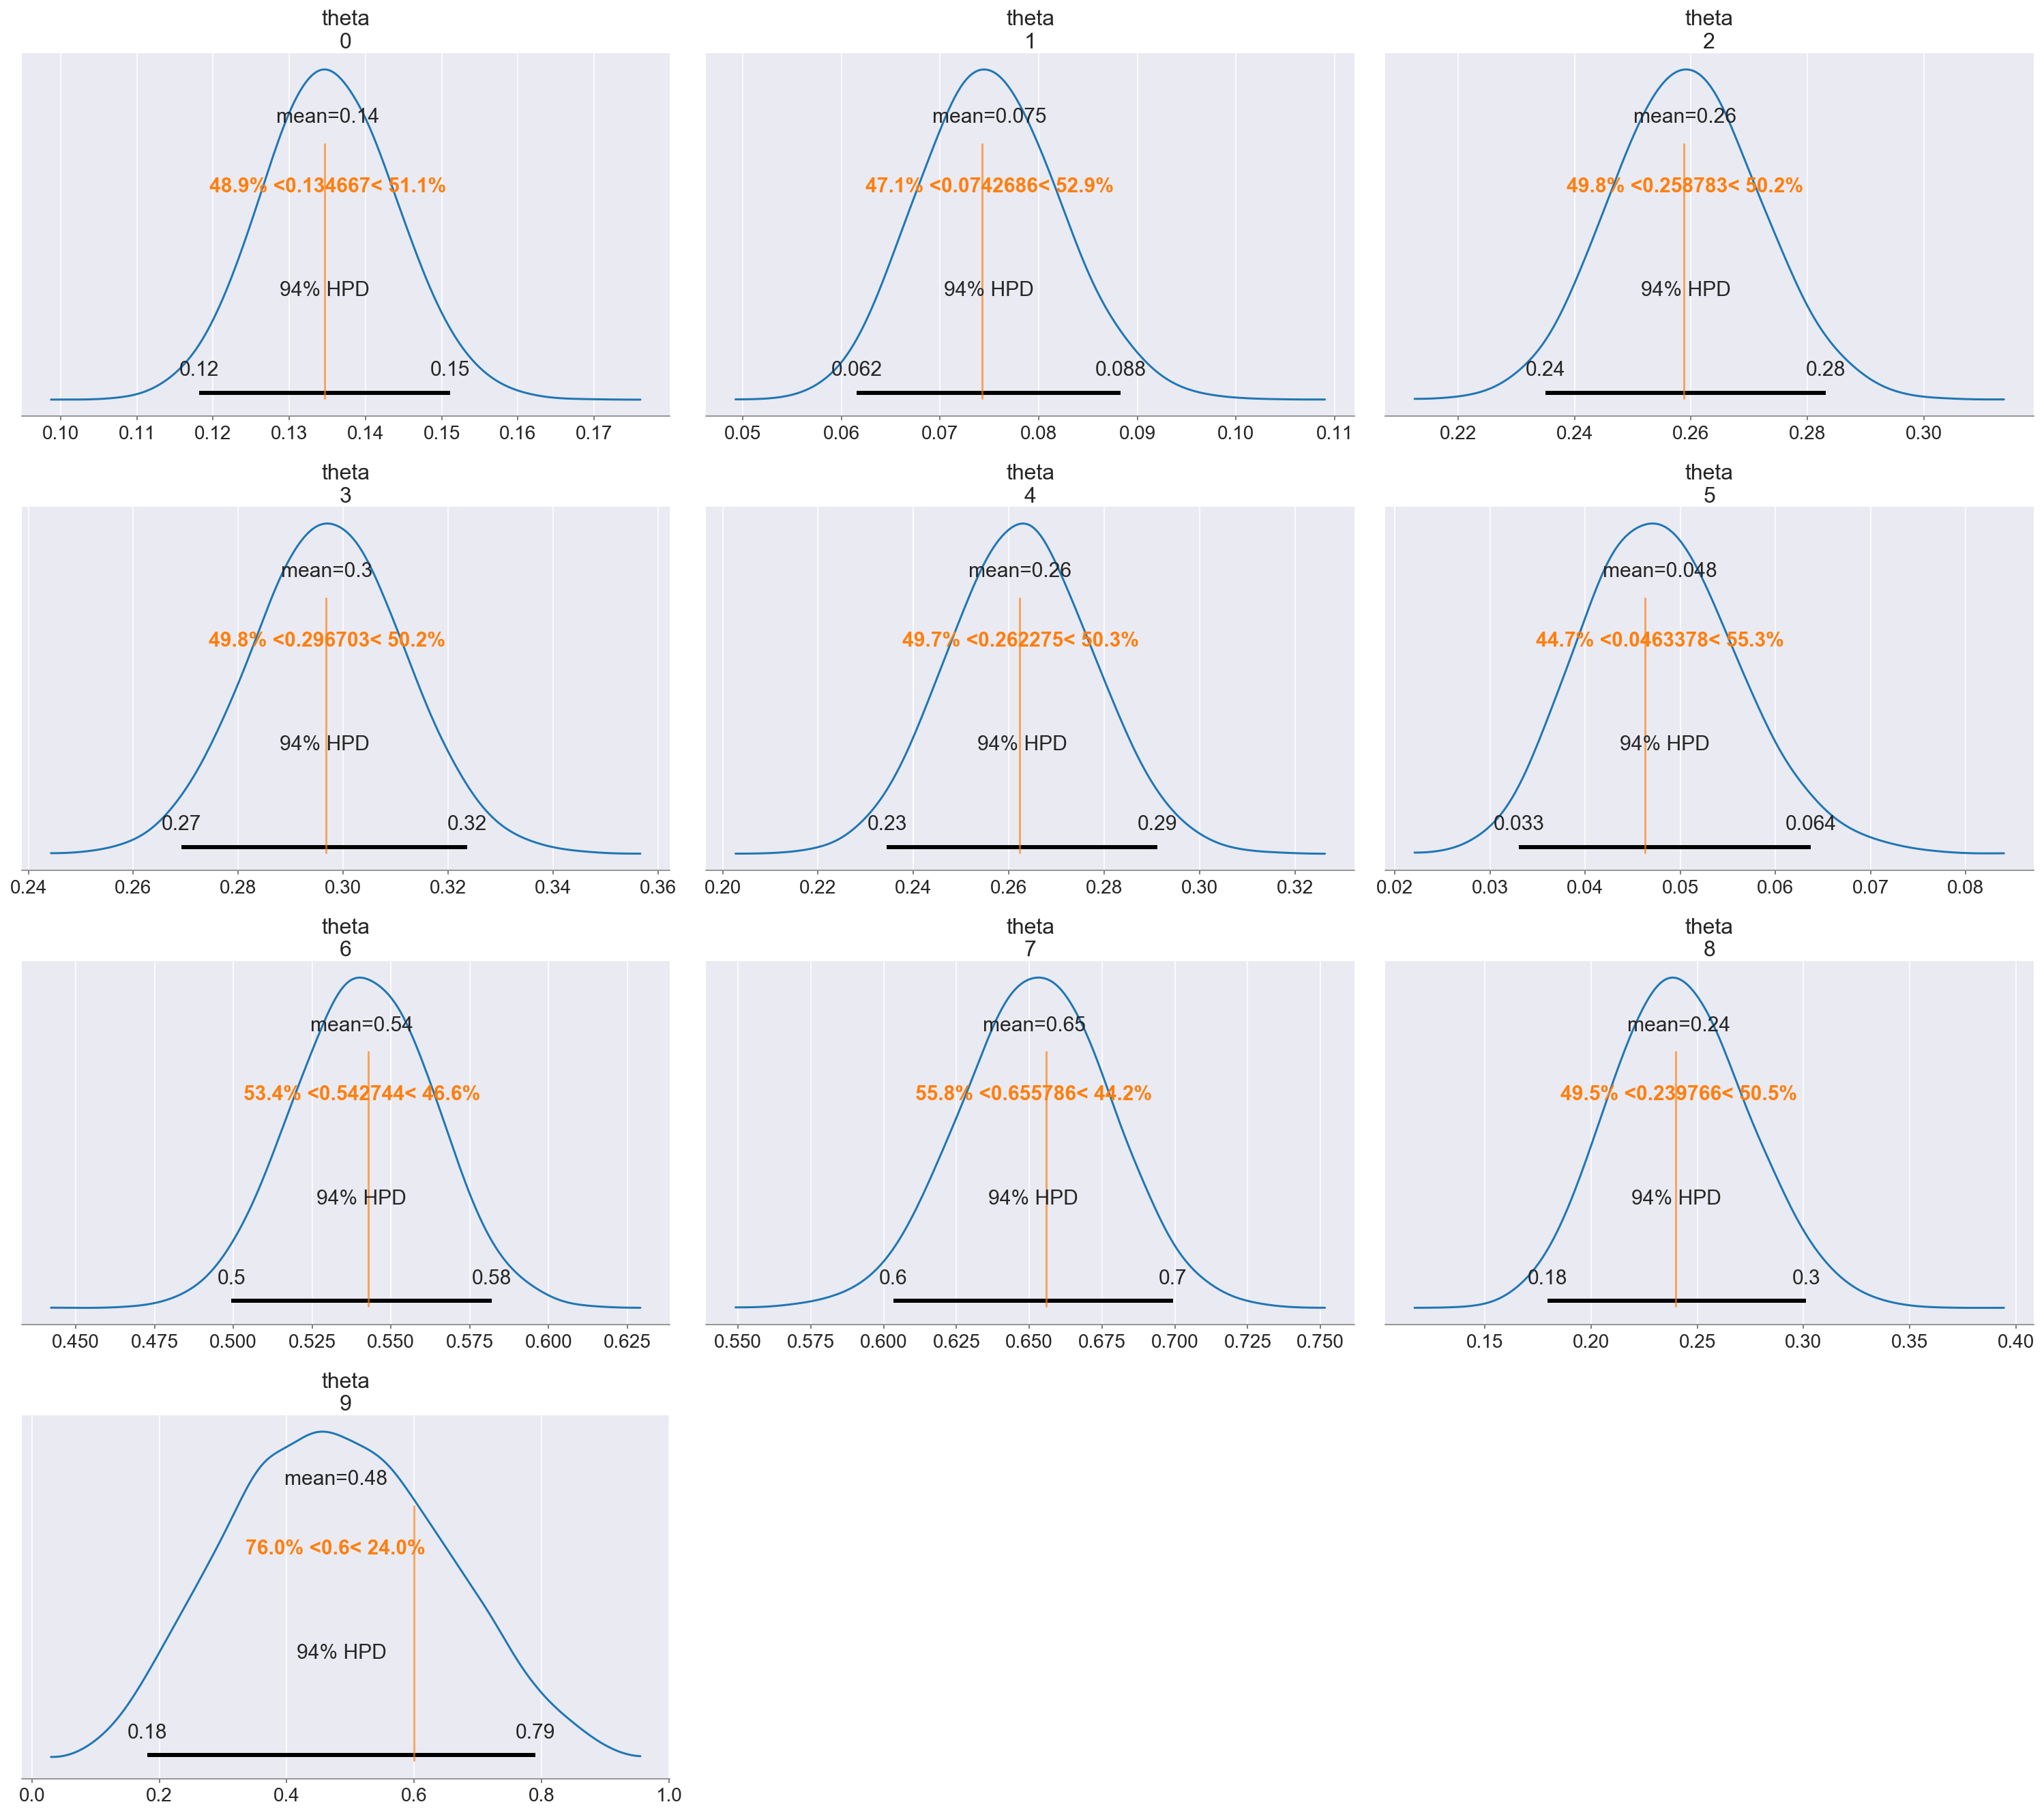

In [27]:
from matplotlib import pyplot as plt

pm.plot_posterior(trace, var_names=["theta"], ref_val=list(observed_p))

This plot shows the true parameters (that we could never observe directly, but useful as a consistency check of the model):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020804F38BE0>,
      dtype=object)

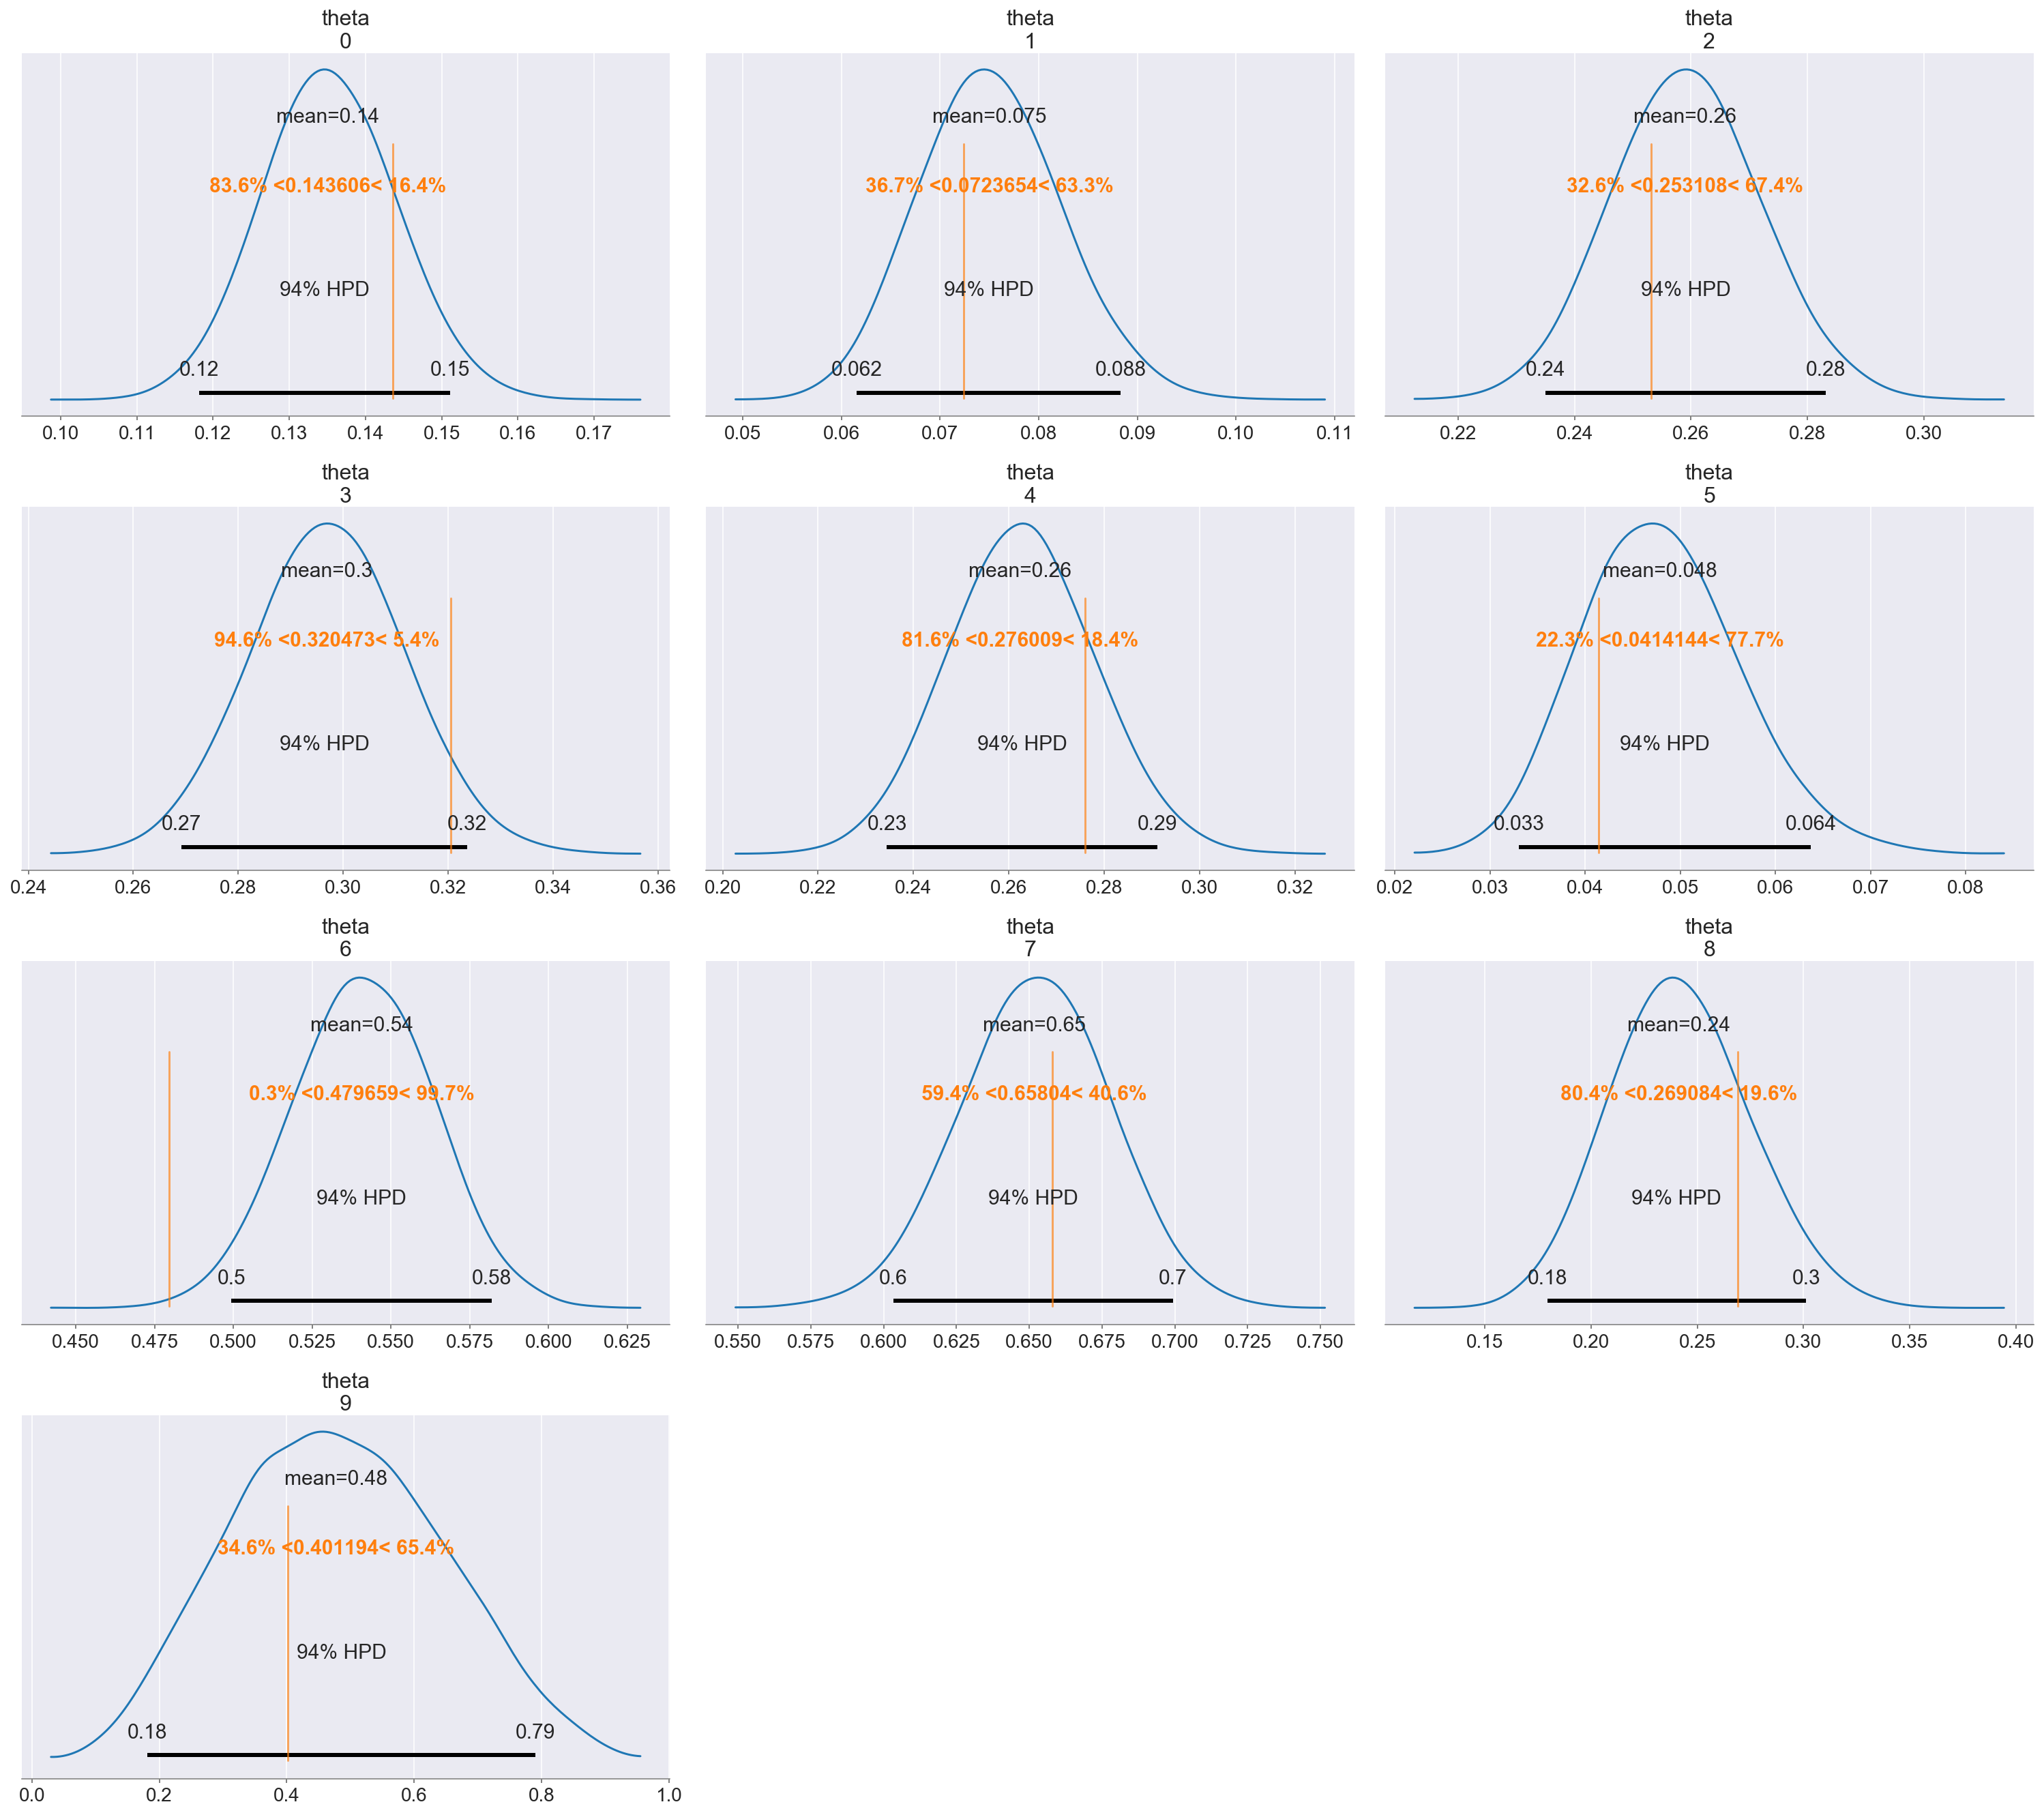

In [28]:
from matplotlib import pyplot as plt

pm.plot_posterior(trace, var_names=["theta"], ref_val=list(SECRET_P))